In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["source", "target", "rating", "timestamp"])


# Preview
print(df.head())
print(df.info())


   source  target  rating     timestamp
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     35592 non-null  int64  
 1   target     35592 non-null  int64  
 2   rating     35592 non-null  int64  
 3   timestamp  35592 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB
None


In [3]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["source", "target", "rating", "timestamp"])

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Sort by sender and time
df = df.sort_values(by=["source", "datetime"])

# Time since last transaction per sender
df["prev_txn_time"] = df.groupby("source")["datetime"].shift(1)
df["time_diff_sec"] = (df["datetime"] - df["prev_txn_time"]).dt.total_seconds()

# Count of transactions per sender/receiver
df["sender_txn_count"] = df.groupby("source").cumcount() + 1
df["receiver_txn_count"] = df.groupby("target").cumcount() + 1

# Rolling average trust score
df["sender_avg_rating"] = df.groupby("source")["rating"].expanding().mean().reset_index(level=0, drop=True)
df["receiver_avg_rating"] = df.groupby("target")["rating"].expanding().mean().reset_index(level=0, drop=True)

# Unique receivers (social diversity)
df["unique_receivers"] = df.groupby("source")["target"].apply(
    lambda x: x.expanding().apply(lambda s: len(set(s)), raw=False)
).reset_index(level=0, drop=True)

# Fill NA values
df.fillna(0, inplace=True)

# Save processed dataset
df.to_csv("processed_bitcoinotc.csv", index=False)


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_10020\2866900466.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_10020\1562605037.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')


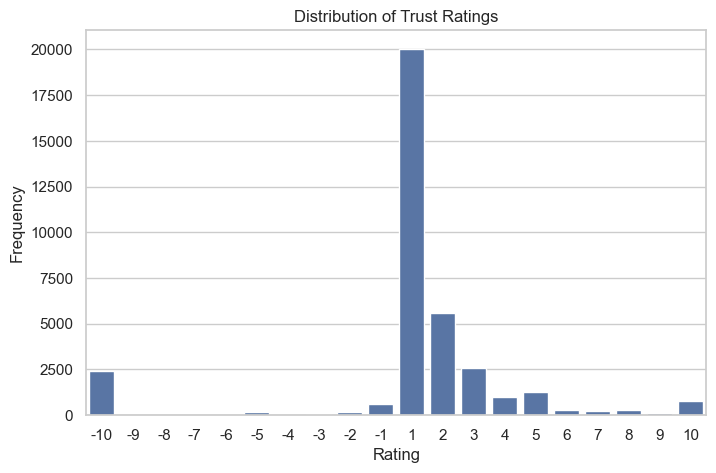

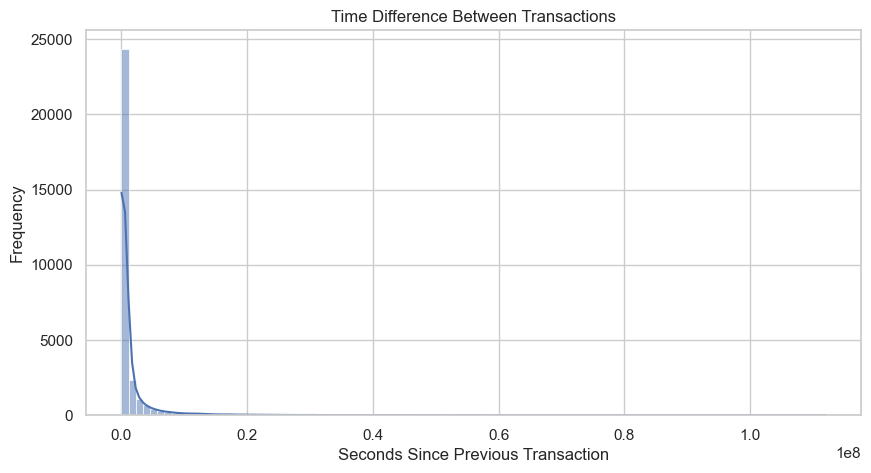

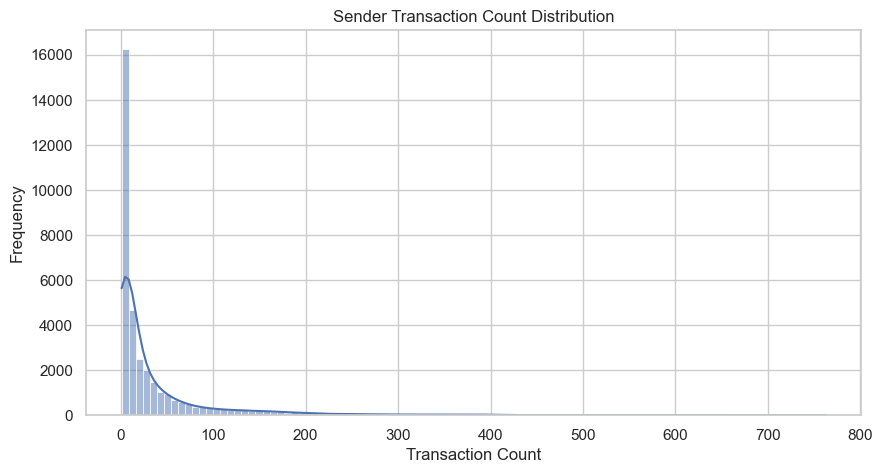

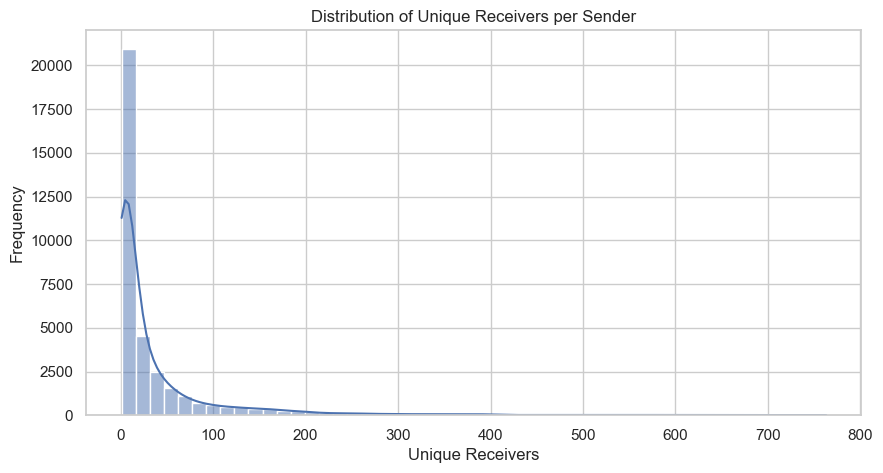

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv("processed_bitcoinotc.csv")

# Convert datetime columns (they may be read as strings)
df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')
df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')

# Seaborn style
sns.set(style="whitegrid")

# ----- 1. Trust Rating Distribution -----
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="rating")
plt.title("Distribution of Trust Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# ----- 2. Time Difference Between Transactions -----
# Clean 'time_diff_sec' for valid values only
df_cleaned = df[
    df['time_diff_sec'].notna() &
    np.isfinite(df['time_diff_sec']) &
    (df['time_diff_sec'] > 0)
]

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["time_diff_sec"], bins=100, kde=True)
plt.title("Time Difference Between Transactions")
plt.xlabel("Seconds Since Previous Transaction")
plt.ylabel("Frequency")
plt.show()

# ----- 3. Sender Transaction Count Distribution -----
plt.figure(figsize=(10, 5))
sns.histplot(df["sender_txn_count"], bins=100, kde=True)
plt.title("Sender Transaction Count Distribution")
plt.xlabel("Transaction Count")
plt.ylabel("Frequency")
plt.show()

# ----- 4. Unique Receivers per Sender -----
plt.figure(figsize=(10, 5))
sns.histplot(df["unique_receivers"], bins=50, kde=True)
plt.title("Distribution of Unique Receivers per Sender")
plt.xlabel("Unique Receivers")
plt.ylabel("Frequency")
plt.show()



In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Select modeling features
features = [
    'time_diff_sec',
    'sender_txn_count',
    'receiver_txn_count',
    'sender_avg_rating',
    'receiver_avg_rating',
    'unique_receivers'
]

# Clean + scale
df_model = df[features].replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df_model['anomaly_score'] = iso_forest.fit_predict(X_scaled)
df_model['is_anomaly'] = df_model['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_model['pca_1'] = X_pca[:, 0]
df_model['pca_2'] = X_pca[:, 1]

# Print anomaly summary
print("Anomaly Counts (Isolation Forest):")
print(df_model['is_anomaly'].value_counts())


Anomaly Counts (Isolation Forest):
is_anomaly
0    34880
1      712
Name: count, dtype: int64


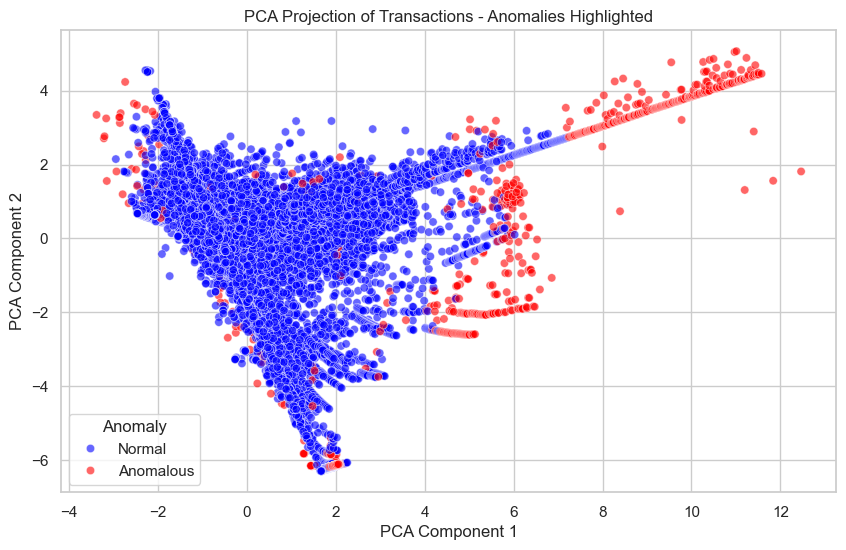

In [6]:
# Save labeled dataset
df_model.to_csv("bitcoinotc_with_isolationforest.csv", index=False)

# Save PCA anomaly plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_model,
    x='pca_1',
    y='pca_2',
    hue='is_anomaly',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Normal", "Anomalous"], title="Anomaly")
plt.title("PCA Projection of Transactions - Anomalies Highlighted")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.savefig("pca_anomaly_plot_isolationforest.png", dpi=300)
plt.show()


Anomaly Counts (One-Class SVM):
is_anomaly_svm
0    34879
1      713
Name: count, dtype: int64


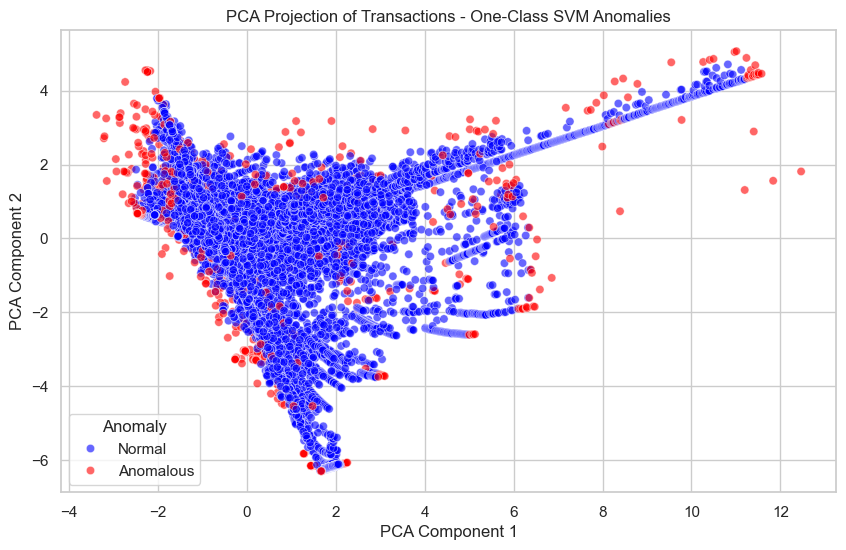

In [7]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same features and scaled data from Isolation Forest step
features = [
    'time_diff_sec',
    'sender_txn_count',
    'receiver_txn_count',
    'sender_avg_rating',
    'receiver_avg_rating',
    'unique_receivers'
]

# Re-scale the data
df_model = df[features].replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Train One-Class SVM
oc_svm = OneClassSVM(kernel="rbf", nu=0.02, gamma='auto')
df_model['svm_score'] = oc_svm.fit_predict(X_scaled)
df_model['is_anomaly_svm'] = df_model['svm_score'].apply(lambda x: 1 if x == -1 else 0)

# PCA for SVM visualization
pca_svm = PCA(n_components=2)
X_pca_svm = pca_svm.fit_transform(X_scaled)
df_model['pca1_svm'] = X_pca_svm[:, 0]
df_model['pca2_svm'] = X_pca_svm[:, 1]

# Save SVM labeled data
df_model.to_csv("bitcoinotc_with_svm.csv", index=False)

# Print anomaly count summary
print("Anomaly Counts (One-Class SVM):")
print(df_model['is_anomaly_svm'].value_counts())

# Plot SVM anomaly PCA
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_model,
    x='pca1_svm',
    y='pca2_svm',
    hue='is_anomaly_svm',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Normal", "Anomalous"], title="Anomaly")
plt.title("PCA Projection of Transactions - One-Class SVM Anomalies")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.savefig("pca_anomaly_plot_svm.png", dpi=300)
plt.show()


In [11]:
# Load both files
df_iforest = pd.read_csv("bitcoinotc_with_isolationforest.csv")
df_svm = pd.read_csv("bitcoinotc_with_svm.csv")

# Merge on all feature columns (make sure index aligns)
merged = df_iforest.copy()
merged['is_anomaly_svm'] = df_svm['is_anomaly_svm']

# Create fraud label: if flagged by either model
merged['is_fraud'] = np.where(
    (merged['is_anomaly'] == 1) | (merged['is_anomaly_svm'] == 1),
    1,
    0
)

# Check label balance
print("Simulated Fraud Labels:")
print(merged['is_fraud'].value_counts())

# Save final dataset
merged.to_csv("bitcoinotc_supervised_labeled.csv", index=False)



Simulated Fraud Labels:
is_fraud
0    34416
1     1176
Name: count, dtype: int64


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("bitcoinotc_supervised_labeled.csv")

# Features and target
features = [
    'time_diff_sec',
    'sender_txn_count',
    'receiver_txn_count',
    'sender_avg_rating',
    'receiver_avg_rating',
    'unique_receivers'
]
X = df[features]
y = df['is_fraud']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# ----------------------
# Logistic Regression
# ----------------------
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("📊 Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

# ----------------------
# Random Forest
# ----------------------
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\n🌲 Random Forest:\n", classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

# ----------------------
# XGBoost
# ----------------------
xgb = XGBClassifier(eval_metric='logloss',
                    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
                    random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\n⚡ XGBoost:\n", classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


📊 Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      6884
           1       0.23      0.80      0.36       235

    accuracy                           0.91      7119
   macro avg       0.61      0.85      0.65      7119
weighted avg       0.97      0.91      0.93      7119

[[6259  625]
 [  48  187]]

🌲 Random Forest:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6884
           1       0.97      0.73      0.83       235

    accuracy                           0.99      7119
   macro avg       0.98      0.87      0.92      7119
weighted avg       0.99      0.99      0.99      7119

[[6879    5]
 [  63  172]]

⚡ XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      6884
           1       0.83      0.86      0.84       235

    accuracy                           0.99      7119
   macro avg      

C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_10020\1957734557.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_10020\1957734557.py:31: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_10020\1957734557.py:31: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Kunal Vishwa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Kunal Vishwa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Kunal Vishwa\AppData\Roaming\Python\Python311\site-

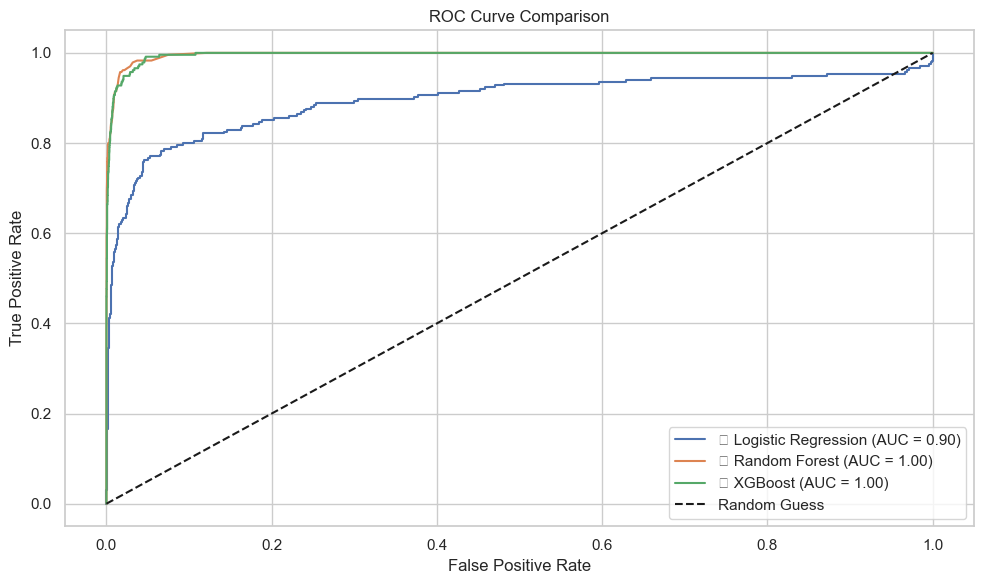

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# AUC Scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"📊 Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"🌲 Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"⚡ XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Make sure this includes all useful columns
final_df = df.copy()

# Add model flags (from merged df with anomalies + fraud labels)
final_df['is_anomaly'] = merged['is_anomaly']
final_df['is_anomaly_svm'] = merged['is_anomaly_svm']
final_df['is_fraud'] = merged['is_fraud']

# Save to CSV for Power BI
final_df.to_csv("fraud_detection_dsp.csv", index=False)
